# Quantum Gaussian Processes

This notebook presents an example of Quantum Gaussian processes




First some usefull packages are imported as well as QGP class. Furthermore our GP system is defined i.e. the kernel matrix, training points $X$ with corresponding observations $y$ as well as querry input $x_s$ for which the prediciton will be done.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer
from qiskit.aqua import QuantumInstance

from QGP import QGP
np.random.seed( 4 )

    
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)


n = 4                                    #size of the system
X = np.random.uniform(0, 10, size=(n,1)) #training inputs
y = np.sin(X)                            #training observations

K = kernel(X, X, 1.0)
matrix = K + np.eye(n)*5.e-2

x_t = np.linspace(0,10,100)
y_t = np.sin(x_t)

plt.plot(X, y, 'o', label = 'training points')
plt.plot(x_t, y_t, '--', label = 'true function')
plt.legend()
plt.grid()
plt.show()


<Figure size 640x480 with 1 Axes>

In Gaussian Processe regression one aims to predict mean value $\mu$ of the underlaying function and uncertainty  $\Sigma$ of the prediction for some querried input $x_s$. Those values can be found as follows:

$$\mu = k_s^T (K(X,X)+\sigma_n^2I)^{-1} y$$

Where $k_s = K(x_s, X)$, $y$  are the training observations and $X$ are the training inputs.

$$\Sigma = K(x_s, x_s) - k_s^T (K(X,X)+\sigma_n^2I)^{-1} k_s$$

The bottleneck of GPs is finding this inverse $(K(X,X)+\sigma_n^2I)^{-1}$, which scales as  $O(N^3)$. This problem is solved in Quantum Gaussian Processes. The algorithm takes as an input a matrix $A$ and 2 vectors $u$ and $v$, and estimates a dot product $uA^{-1}v$. Here the inversion of the matrix is implemented with HHL algorithm, which requires only $O(log(N))$ operations, thus providing exponential speedup. 

Therefore to estimate $\mu$ the inputs are:

$$u = k_s^T$$
$$v = y$$
$$A = (K(X,X)+\sigma_n^2I)$$


While to estimate $\Sigma$:
$$u = k_s^T$$
$$v = k_s$$
$$A = (K(X,X)+\sigma_n^2I)$$


In [4]:
x_s = np.array([[6.5]])
k_s = kernel(x_s, X, 1)

print(matrix)
print(k_s)
print(y)

[[1.05000000e+00 1.49009451e-04 9.98402597e-01 4.15610774e-02]
 [1.49009451e-04 1.05000000e+00 1.17335298e-04 2.45559605e-01]
 [9.98402597e-01 1.17335298e-04 1.05000000e+00 3.59795443e-02]
 [4.15610774e-02 2.45559605e-01 3.59795443e-02 1.05000000e+00]]
[[0.00656899 0.58974766 0.00548214 0.81053914]]
[[-0.24306118]
 [-0.72488181]
 [-0.29749295]
 [ 0.76107881]]


In current implementation QGP is limited to only positive vectors (all entries must be positive). While vectors $k_s$ satisfies this requirement (values of K are always positive because given by exp), y might be negative. A simple solution is to translate the problem i.e. add some constatn to shift everythig up.

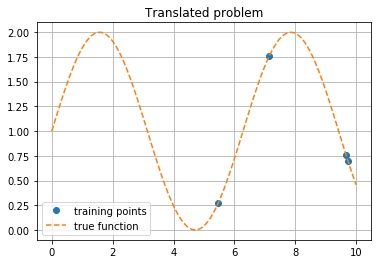

In [5]:
offset =  1.
y_t = y_t  + offset
y = y+offset


plt.plot(X, y, 'o', label = 'training points')
plt.plot(x_t, y_t, '--', label = 'true function')
plt.legend()
plt.title('Translated problem')
plt.grid()
plt.show()


Next some input parameters are defined for QGP (and implicitly HHL) algorithm:

In [6]:
w, mu = np.linalg.eig(matrix)
print('Eigenvalues: ', w)

u = k_s.reshape(-1,1)
v = y

params = {
'algorithm': {
        'name': 'HHL',
        'num_ancillae': 6, 
        'num_time_slices': 80,
        'expansion_mode': 'suzuki',
        'expansion_order': 2,
        'negative_evals':False,
},
'eigs': {
       'name': 'EigsQPE',
        'num_ancillae': 6,
        'num_time_slices': 80,
       'expansion_mode': 'suzuki',
        'expansion_order': 2,
        'negative_evals':False,
},
"iqft": {
    "name": "STANDARD"
},
"qft": {
    "name": "STANDARD"
},
"initial_state": {
    "name": "CUSTOM",
    "state_vector": v,
},
'reciprocal': {
        'name': 'Lookup',
        #'pat_length': 4, # eigenvalue register
        #'subpat_length': 3,
        #'scale': 0,
        'negative_evals':False, 
        'evo_time': None, 
        'lambda_min': min(w),
},
}        


Eigenvalues:  [2.05160145 0.05158082 1.29356892 0.80324881]


In [7]:
print(u.shape, v.shape, matrix.shape)
np.dot(u.T, np.linalg.solve(matrix, v))

(4, 1) (4, 1) (4, 4)


array([[1.28996548]])

Next a class instance is initialized and then executed to obtain estimate on $mu$. The algorithm can be executed either on statevector simulator or qasm simulator (as on quantum computer, works with shots). 

In [8]:
qgp_mu = QGP().init_params(params, u, v, matrix)
backend = Aer.get_backend('statevector_simulator')
qgp_mu._quantum_instance = QuantumInstance(backend)
qgp_mu._run()
print(qgp_mu._ret)

{'qgp_result': (1.3230833598461036+0j), 'classical_result': array([[1.28996548]]), 'error%': 2.56734613937812, 'input_matrix': array([[1.05000000e+00, 1.49009451e-04, 9.98402597e-01, 4.15610774e-02],
       [1.49009451e-04, 1.05000000e+00, 1.17335298e-04, 2.45559605e-01],
       [9.98402597e-01, 1.17335298e-04, 1.05000000e+00, 3.59795443e-02],
       [4.15610774e-02, 2.45559605e-01, 3.59795443e-02, 1.05000000e+00]]), 'input_vector_v': array([[0.75693882],
       [0.27511819],
       [0.70250705],
       [1.76107881]]), 'input_vector_u': array([[0.00656899],
       [0.58974766],
       [0.00548214],
       [0.81053914]]), 'eigenvalues_classical': array([2.05160145, 0.05158082, 1.29356892, 0.80324881]), 'circuit_width': 13, 'circuit_depth': 469659, 'gate_count_total': 470672, 'execution_time': 1387.72065615654}


In [11]:
mu  = qgp_mu._ret['qgp_result']
mu_an = qgp_mu._ret['classical_result']

print('Error:', qgp_mu._ret['error%'], '%')

Error: 2.56734613937812 %


To get estimate on variance, only vector $v$ needs to be changed to $k_s$

In [12]:
v = k_s
qgp_s = QGP().init_params(params, u, v, matrix)
backend = Aer.get_backend('statevector_simulator')
qgp_s._quantum_instance = QuantumInstance(backend)
qgp_s._run()
print(qgp_s._ret)

{'qgp_result': (0.8069612065828029+0j), 'classical_result': array([[0.787514]]), 'error%': 2.469442097292433, 'input_matrix': array([[1.05000000e+00, 1.49009451e-04, 9.98402597e-01, 4.15610774e-02],
       [1.49009451e-04, 1.05000000e+00, 1.17335298e-04, 2.45559605e-01],
       [9.98402597e-01, 1.17335298e-04, 1.05000000e+00, 3.59795443e-02],
       [4.15610774e-02, 2.45559605e-01, 3.59795443e-02, 1.05000000e+00]]), 'input_vector_v': array([[0.00656899],
       [0.58974766],
       [0.00548214],
       [0.81053914]]), 'input_vector_u': array([[0.00656899],
       [0.58974766],
       [0.00548214],
       [0.81053914]]), 'eigenvalues_classical': array([2.05160145, 0.05158082, 1.29356892, 0.80324881]), 'circuit_width': 13, 'circuit_depth': 469659, 'gate_count_total': 470672, 'execution_time': 1402.8456060886383}


In [13]:
var  = kernel(x_s, x_s, 1.) - qgp_mu._ret['qgp_result']
var_an  = kernel(x_s, x_s, 1.) - qgp_mu._ret['classical_result']

Now we have the result. The whole problem can be then translated back by subtracting 'offset'

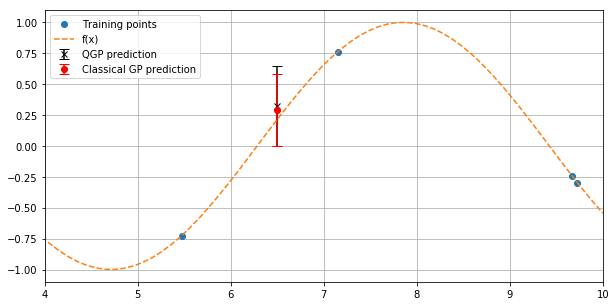

In [27]:
plt.figure(figsize = (10,5))
plt.plot(X, y-offset, 'o', label = 'Training points')
plt.errorbar(x_s, mu-offset, yerr = var,fmt = 'kx',  label = 'QGP prediction', capsize = 5)
plt.errorbar(x_s, mu_an-offset, yerr = var_an,fmt = 'ro', label = 'Classical GP prediction', capsize = 5)
plt.plot(x_t, y_t-offset, '--', label = 'f(x)')
plt.xlim([4,10])
plt.legend()
plt.grid()
plt.show()

